This notebook replicates the code for Lesson 7 of QF607

# 👉 <a id = "top">Table of Contents</a> 👈 

# [1. Pricer](#p1)

# [2. Tradable](#p2)

# [3. Volsurf](#p3)

# [4. Dupire](#p4)

# [5. Tests](#p5)

In [1]:
import math
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
import bisect
from scipy import optimize
from scipy.interpolate import CubicSpline

# <a id = "p1">1.</a>  <font color = "green"> Pricer </font>  [back to table of contents](#top)

In [2]:
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

In [3]:
# Black-Scholes analytic pricer
def bsPrice(S, r, q, vol, T, strike, payoffType):
    fwd = S * math.exp((r-q) * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    elif payoffType == PayoffType.BinaryCall:
        return math.exp(-r * T) * cnorm(d1)
    elif payoffType == PayoffType.BinaryPut:
        return math.exp(-r * T) * (1-cnorm(-d1))
    else:
        raise Exception("not supported payoff type", payoffType)

In [4]:
class BlackScholesMC:
    def __init__ (self, S0, vol, r, q):
        self.vol, self.S0, self.r, self.q = vol, S0, r, q
    def NumberOfFactors(self):
        return 1
    def GetTimeSteps(self, eventDates):
        # black scholes diffusion is exact, no need to add more dates
        return eventDates
    def Diffuse(self, dts, bs):
        xs = [math.log(self.S0)]
        dd = [0.0]
        for i in range(1, len(dts)+1):
            a = (self.r - self.q - 0.5 * self.vol * self.vol) * dts[i-1] #EQ9
            b = self.vol * bs[0, i-1] * math.sqrt(dts[i-1])
            xs.append(xs[i-1] + a + b)
            dd.append(dts[i-1])
        return (lambda t: math.exp(np.interp(t, dd, xs)))

In [5]:
class LocalVolMC:
    def __init__ (self, S0, T, lv, r, q):
        self.lv, self.S0, self.T, self.r, self.q = lv, S0, T, r, q
    def NumberOfFactors(self):
        return 1
    def GetTimeSteps(self, eventDates):
        nT = 100
        dt = self.T / nT
        for i in range(1, nT):
            eventDates.append(dt * i)
        return eventDates
    
    def Diffuse(self, dts, bs):
        xs = [math.log(self.S0)]
        dd = [0.0]
        for i in range(1, len(dts)):
            dt = dts[i] - dts[i-1]
            vol = self.lv.LV(dts[i], math.exp(xs[i-1]))
            a = (self.r - self.q - 0.5 * vol * vol) * dt
            b = vol * bs[0, i-1] * math.sqrt(dt)
            xs.append(xs[i-1] + a + b)
            dd.append(dts[i-1]) #dt
        return (lambda t: math.exp(np.interp(t, dd, xs)))

In [6]:
class DeterminsticIR:
    def __init__ (self, r):
        self.r = r
    def NumberOfFactors(self):
        return 0
    def GetTimeSteps(self, eventDates):
        return eventDates
    def Diffuse(self, dts, bs):
        return(lambda t: math.exp(-self.r*t))

In [7]:
def mcPricer(trade, models, corrMat, nPaths):
    assetNames = trade.assetNames() # get all the assets involved for the payoff
    C = corrMat # get correlation matrix from the market
    numFactors = C.shape[0] # get total number of factors (brownians)
    L = np.linalg.cholesky(C) # cholesky decomposition
    dts = [] # get simulation time steps
    for a in assetNames:
        dts += (models[a].GetTimeSteps(trade.AllDates()))    
    dts = np.unique(dts)
    dts = np.sort(dts)

    sum, hsquare, nT = 0, 0, len(dts)
    for i in range(nPaths):
        # generate independent brownian increments,
        brownians = np.zeros((numFactors, nT))
        for j in range(numFactors):
            brownians[j] = np.random.normal(0, 1, nT)
        brownians = np.matmul(L, brownians) # correlate them using L
        bidx, fobs = 0, dict() # fobs is a dict from asset name to observable,
        # each observable if a function from t to the observation price
        for k in assetNames:
            # pass the brownians to the model to generate the observation functions
            model = models[k]
            nF = model.NumberOfFactors()
            bs = brownians[bidx:bidx+nF, :] # (bidx:bidx + nF, :]
            fobs[k] = model.Diffuse(dts, bs)
            bidx += nF
        # call the payoff function to obtain the discounted cashflows
        h = trade.DiscountedMCPayoff(fobs)
        sum += h
        hsquare += h*h
    pv = sum / nPaths
    se = math.sqrt((hsquare/nPaths - pv*pv)/nPaths)
    return pv, se

In [8]:
def pdePricerX(S0, r, q, lv, NX, NT, w, trade):
    # set up pde grid
    mu = r - q
    T = trade.expiry
    X0 = math.log(S0)
    vol0 = lv.LV(0, S0)
    srange = 5 * vol0 * math.sqrt(T)
    maxX = X0 + (mu - vol0 * vol0 * 0.5)*T + srange
    minX = X0 - (mu - vol0 * vol0 * 0.5)*T - srange
    dt = T / (NT-1)
    dx = (maxX - minX) / (NX-1)
    # set up spot grid
    xGrid = np.array([minX + i*dx for i in range(NX)])
    # initialize the payoff
    ps = np.array([trade.payoff(math.exp(x)) for x in xGrid])
    # backward induction
    for j in range(1, NT):
        # set up the matrix, for LV we need to update it for each iteration
        M = np.zeros((NX, NX))
        D = np.zeros((NX, NX))
        for i in range(1, NX - 1):
            vol = lv.LV(j*dt, math.exp(xGrid[i]))
            M[i, i - 1] = (mu - vol * vol / 2.0) / 2.0 / dx - vol * vol / 2 / dx / dx
            M[i, i] = r + vol * vol / dx / dx
            M[i, i + 1] = -(mu - vol * vol / 2.0) / 2.0 / dx - vol * vol / 2 / dx / dx
            D[i, i] = 1.0
        # the first row and last row depends on the boundary condition
        M[0, 0], M[NX - 1, NX - 1] = 1.0, 1.0
        rhsM = (D - dt * M) * w + (1 - w) * np.identity(NX)
        lhsM = w * np.identity(NX) + (D + dt * M) * (1 - w)
        inv = np.linalg.inv(lhsM)

        ps = rhsM.dot(ps)
        ps[0] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[0])) # discounted payoff
        ps[NX-1] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[NX-1]))
        ps = inv.dot(ps)
    # linear interpolate the price at S0
    return np.interp(X0, xGrid, ps)

In [9]:
def simpleCRR(r, vol, t):
    u = math.exp(vol * math.sqrt(t))
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1 / u, p)

In [10]:
def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

In [11]:
def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

In [12]:
def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

In [13]:
def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

In [14]:
def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

In [15]:
# binomial, with multi states, for path dependent products
def binomialPricerX(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.valueAtNode(trade.expiry, S * u ** (n - i) * d ** i, None) for i in range(n + 1)]
    numStates = len(vs[0])
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = [math.exp(-r * t) * (vs[j][k] * p + vs[j + 1][k] * (1 - p)) for k in range(numStates)]
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0][0]

In [16]:
def calib2D(r, q1, q2, vol1, vol2, rho, t):
    sqrtt = math.sqrt(t)
    v1 = r - q1 - vol1 * vol1 / 2
    v2 = r - q2 - vol2 * vol2 / 2
    x1 = vol1 * sqrtt
    x2 = vol2 * sqrtt
    a = x1 * x2
    b = x2 * v1 * t
    c = x1 * v2 * t
    d = rho * vol1 * vol2 * t
    puu = (a + b + c + d)/4/a
    pud = (a + b - c - d)/4/a
    pdu = (a - b + c - d)/4/a
    pdd = (a - b - c + d)/4/a
    return (x1, x2, puu, pud, pdu, pdd)

In [17]:
def binomialPricer2D(S1, S2, r, q1, q2, vol1, vol2, rho, trade, n):
    t = trade.expiry / n
    (x1, x2, puu, pud, pdu, pdd) = calib2D(r, q1, q2, vol1, vol2, rho, t)
    vs = np.zeros(shape=(n+1, n+1))
    for i in range(n+1):
        s1i = S1 * math.exp(x1 * (n - 2 * i))
        for j in range(n+1):
            s2j = S2 * math.exp(x2 * (n - 2*j))
            vs[i, j] = trade.payoff(s1i, s2j)
    # iterate backward
    for k in range(n - 1, -1, -1):
        # calculate the value of each node at time slide k, there are (k+1) x (k+1) nodes
        for i in range(k + 1):
            s1i = S1 * math.exp(x1 * (k - 2*i))
            for j in range(k + 1):
                s2j = S2 * math.exp(x2 * (k - 2*j))
                continuation = math.exp(-r * t) * (vs[i, j] * puu + vs[i, j+1] * pud + vs[i+1, j] * pdu + vs[i+1, j+1] * pdd)
                vs[i, j] = trade.valueAtNode(t * k, s1i, s2j, continuation)
    return vs[0, 0]

In [18]:
def trinomialPricer(S, r, q, vol, trade, n, lmda):
    t = trade.expiry / n
    u = math.exp(lmda * vol * math.sqrt(t))
    mu = r - q
    pu = 1 / 2 / lmda / lmda + (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pd = 1 / 2 / lmda / lmda - (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pm = 1 - pu - pd
    # set up the last time slice, there are 2n+1 nodes at the last time slice
    # counting from the top, the i-th node's stock price is S * u^(n - i), i from 0 to n+1
    vs = [trade.payoff(S * u ** (n - i)) for i in range(2*n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(2*i + 1):
            nodeS = S * u ** (i - j)
            continuation = math.exp(-r * t) * (vs[j] * pu +  + vs[j+1] * pm + vs[j+2] * pd)
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

# <a id = "p2">2.</a>  <font color = "green"> Tradable </font>  [back to table of contents](#top)

In [19]:
class PayoffType(Enum):
    Call = 0
    Put = 1
    BinaryCall = 2
    BinaryPut = 3

In [20]:
class AsianOption():
    def __init__(self, assetName, asset, fixings, payoffFun, As, nT):
        self.assetName = assetName
        self.fixings = fixings
        self.payoffFun = payoffFun
        self.expiry = fixings[-1]
        self.nFix = len(fixings)
        self.As, self.nT, self.dt = As, nT, self.expiry / nT
        self.asset = asset
    def onFixingDate(self, t):
        # we say t is on a fixing date if there is a fixing date in (t-dt, t]
        return filter(lambda x: x > t - self.dt and x<=t, self.fixings)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return [self.payoffFun((a*float(self.nFix-1) + S)/self.nFix) for a in self.As]
        else:
            nodeValues = continuation
            if self.onFixingDate(t):
                i = len(list(filter(lambda x: x < t, self.fixings))) # number of previous fixings
                if i > 0:
                    Ahats = [(a*(i-1) + S)/i for a in self.As]
                    nodeValues = [np.interp(a, self.As, continuation) for a in Ahats]
        return nodeValues
    def AllDates(self):
        return self.fixings
    def DiscountedMCPayoff(self, fobs):
        df = fobs["DF.USD"](self.fixings[-1])
        avg = 0
        for t in self.fixings:
            avg += fobs[self.assetName](t)
        return df * self.payoffFun(avg / self.nFix)
    def assetNames(self):
        return [self.assetName, "DF.USD"]

In [21]:
class EuropeanOption():
    def __init__(self, assetName, expiry, strike, payoffType):
        self.assetName = assetName
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        elif self.payoffType == PayoffType.BinaryCall:
            if S > self.strike:
                return 1.0
            else:
                return 0.0
        elif self.payoffType == PayoffType.BinaryPut:
            if S < self.strike:
                return 1.0
            else:
                return 0.0
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

    def assetNames(self):
        return [self.assetName, "DF.USD"]

    def AllDates(self):
        return [self.expiry]

    def DiscountedMCPayoff(self, fobs):
        df = fobs["DF.USD"](self.expiry)
        po = self.payoff(fobs[self.assetName](self.expiry))
        return po * df

In [22]:
class EuropeanPayoff():
    def __init__(self, expiry, payoffFun):
        self.expiry = expiry
        self.payoffFun = payoffFun
    def payoff(self, S):
        return self.payoffFun(S)
    def valueAtNode(self, t, S, continuation):
        return continuation

In [23]:
class SpreadOption():
    def __init__(self, asset1, asset2, expiry):
        self.expiry = expiry
        self.asset1, self.asset2 = asset1, asset2
    def payoff(self, S1, S2):
        return max(S1-S2, 0)
    def valueAtNode(self, t, S1, S2, continuation):
        return continuation
    def AssetNames(self):
        return [self.asset1, self.asset2, "DF.USD"]
    def AllDates(self):
        return [self.expiry]
    def DiscountedMCPayoff(self, fobs):
        df = fobs["DF.USD"](self.expiry)
        s1 = fobs[self.asset1](self.expiry)
        s2 = fobs[self.asset2](self.expiry)
        return df * max(s1 - s2, 0)

In [24]:
class Tarf:
    def __init__(self, assetName, fixings, payoffFun, targetGain):
        self.fixings = fixings
        self.payoffFun = payoffFun
        self.assetName = assetName
        self.targetGain = targetGain
    def AllDates(self):
        return self.fixings
    def DiscountedMCPayoff(self, fobs):
        df = fobs["DF.USD"](self.fixings[-1])
        accum, discountedPO = 0, 0
        for t in self.fixings:
            df = fobs["DF.USD"](t)
            po = self.payoffFun(fobs[self.assetName](t))
            accum += po
            discountedPO += df * po
            if (accum > self.targetGain):
                break # triggers knockout
        return discountedPO
    def assetNames(self):
        return [self.assetName, "DF.USD"]

# <a id = "p3">3.</a>  <font color = "green"> Volsurf </font>  [back to table of contents](#top)

In [25]:
class SmileCubicSpline:
    def __init__(self, strikes, vols):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes + [1.1 * strikes[-1] - 0.1 * strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1] - vols[-2]) / 10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)

    def Vol(self, k):
        if k < self.strikes[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)

In [26]:
class FlatVol:
    def __init__(self, vol):
        self.vol = vol
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        return self.vol

    def dVoldK(self, t, k):
        return 0
    def dVoldT(self, t, k):
        return 0
    def dVol2dK2(self, t, k):
        return 0

In [27]:
class ImpliedVol:
    def __init__(self, ts, smiles):
        self.ts = ts
        self.smiles = smiles
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts)-1:
            return self.smiles[-1].Vol(k)
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return

    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.001) - self.Vol(t, k-0.001)) / 0.002
    def dVoldT(self, t, k):
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.001) + self.Vol(t, k-0.001) - 2*self.Vol(t, k)) / 0.000001

In [28]:
def fwdDelta(fwd, stdev, strike, payoffType):
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return - cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)

In [29]:
# solve for the K such that Delta(S, T, K, vol) = delta
def strikeFromDelta(S, r, q, T, vol, delta, payoffType):
    fwd = S * math.exp((r-q) * T)
    if payoffType == PayoffType.Put:
        delta = -delta
    f = lambda K: (fwdDelta(fwd, vol * math.sqrt(T), K, payoffType) - delta)
    a, b = 0.0001, 10000
    return optimize.brentq(f, a, b)

In [30]:
def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10):
    c25 = bf25 + atmvol + rr25/2
    p25 = bf25 + atmvol - rr25/2
    c10 = bf10 + atmvol + rr10/2
    p10 = bf10 + atmvol - rr10/2

    ks = [ strikeFromDelta(S, r, q, T, p10, 0.1, PayoffType.Put),
           strikeFromDelta(S, r, q, T, p25, 0.25, PayoffType.Put),
           S * math.exp((r-q)*T),
           strikeFromDelta(S, r, q, T, c25, 0.25, PayoffType.Call),
           strikeFromDelta(S, r, q, T, c10, 0.1, PayoffType.Call) ]
    # print(T, ks)
    return SmileCubicSpline(ks, [p10, p25, atmvol, c25, c10])

In [31]:
class LocalVol:
    def __init__(self, iv, S0, rd, rf):
        self.iv = iv
        self.S0 = S0
        self.rd = rd
        self.rf = rf
    def LV(self, t, s):
        if t < 1e-6:
            return self.iv.Vol(t, s)
        imp = self.iv.Vol(t, s)
        dvdk = self.iv.dVoldK(t, s)
        dvdt = self.iv.dVoldT(t, s)
        d2vdk2 = self.iv.dVol2dK2(t, s)
        d1 = (math.log(self.S0/s) + (self.rd-self.rf)*t + imp * imp * t / 2) / imp / math.sqrt(t)
        numerator = imp*imp + 2*t*imp*dvdt + 2*(self.rd-self.rf)*s*t*imp*dvdk
        denominator = (1+s*d1*math.sqrt(t)*dvdk)**2 + s*s*t*imp*(d2vdk2 - d1 * math.sqrt(t) * dvdk * dvdk)
        localvar = min(max(numerator / denominator, 1e-8), 1.0)
        if numerator < 0: # floor local volatility
            localvar = 1e-8
        if denominator < 0: # cap local volatility
            # print(t, s,  dvdk, dvdt, d2vdk2, d1)
            localvar = 1.0
        return math.sqrt(localvar)

# <a id = "p4">4.</a>  <font color = "green"> Dupire </font>  [back to table of contents](#top)

In [32]:
# the PDE calibration error report takes a implied volatility surface,
# verifies the pricing error of the pde pricer with local volatility surface
def pdeCalibReport(S0, r, q, impliedVol):
    ts = [0.02, 0.04, 0.06, 1/12.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 5]
    ds = np.arange(0.9, 0., -0.1)
    # ds = np.arange(0.5, 1.7, 0.1)
    err = np.zeros((len(ds), len(ts)))
    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(ts)))
    ax.set_yticks(np.arange(len(ds)))
    ax.set_xticklabels(map(lambda t : round(t, 2), ts))
    ax.set_yticklabels(map(lambda d : round(d, 1), ds))

    # create local vol surface
    lv = LocalVol(impliedVol, S0, r, q)
    # Loop over data dimensions and create text annotations.
    for i in range(len(ds)):
        for j in range(len(ts)):
            T = ts[j]
            K = strikeFromDelta(S0, r, 0, T, iv.Vol(T, S0*math.exp(r*T)), ds[i], PayoffType.Put)
            payoff = PayoffType.Put
            trade = EuropeanOption("ASSET1", T, K, payoff)
            vol = impliedVol.Vol(ts[j], K)
            bs = bsPrice(S0, r, q, vol, T, K, payoff)
            pde = pdePricerX(S0, r, q, lv, max(50, int(50 * T)), max(50, int(50 * T)), 0.5, trade)
            # normalize error in 1 basis point per 1 unit of stock
            err[i, j] = math.fabs(bs - pde)/S0 * 10000
            ax.text(j, i, round(err[i, j], 1), ha="center", va="center", color="w")
    im = ax.imshow(err)
    ax.set_title("Dupire Calibration PV Error Matrix")
    fig.tight_layout()
    plt.show()

In [33]:
def createTestImpliedVol(S, r, q, sc):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i]*sc, rr25s[i]*sc, bf10s[i]*sc, rr10s[i]*sc) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

In [34]:
def plotTestImpliedVolSurface(iv):
    tStart, tEnd = 0.02, 5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Put)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Call)
    ks = np.arange(kmin, kmax, 0.01)
    vs = np.ndarray((len(ts), len(ks)))
    lv = LocalVol(iv, S, r, q)
    lvs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])
            lvs[i, j] = lv.LV(ts[i], ks[j])
    hf = plt.figure(figsize=(8, 6), dpi=80)
    ha = hf.add_subplot(121, projection='3d')
    hb = hf.add_subplot(122, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs)
    ha.set_title("implied vol")
    ha.set_xlabel("strike")
    ha.set_ylabel("T")
    hb.plot_surface(X, Y, lvs)
    hb.set_title("local vol")
    hb.set_xlabel("strike")
    hb.set_ylabel("T")
    plt.show()

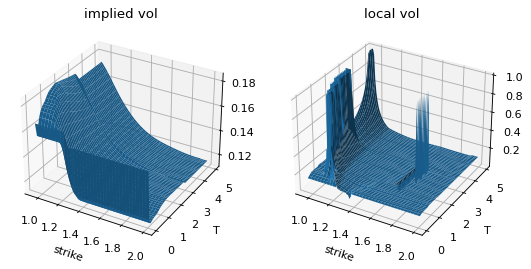

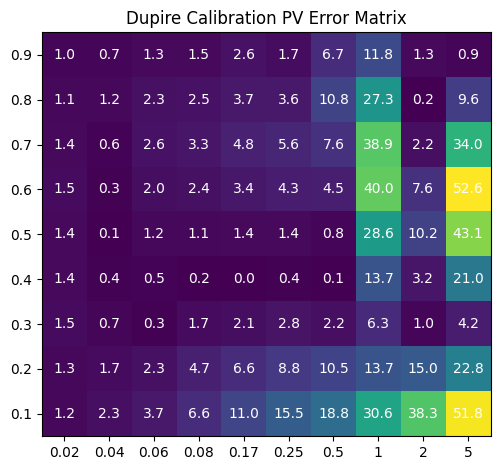

In [35]:
if __name__ == "__main__":
    S, r, q = 1.25805, 0.01, 0.0
    iv = createTestImpliedVol(S, r, q, 1.0)
    plotTestImpliedVolSurface(iv)
    pdeCalibReport(S, r, q, iv)

# <a id = "p5">5.</a>  <font color = "green"> Tests </font>  [back to table of contents](#top)

In [36]:
assetCode = "ASSET1"
df = "DF.USD"

In [37]:
S = 100.0
K = 100.0
r = 0.01
q = 0.0
vol = 0.1
T = 1.0

In [38]:
opt = EuropeanOption(assetCode, T, K, PayoffType.Call)
payoff = lambda A: max(A - 100.0, 0)
asiaOpt = AsianOption(assetCode, "Stock1", [0.2, 0.4, 0.6, 0.8, 1.0], payoff, None, T)
targetGain = 10.0
tarfOpt = Tarf(assetCode, [0.2, 0.4, 0.6, 0.8, 1.0], payoff,targetGain)

In [39]:
def testBSMC():
    print("BS analytic European Price/Std : ", bsPrice(S, r, q, vol, opt.expiry, opt.strike, opt.payoffType))
    print("CRR binomial European Price/Std : ", binomialPricer(S, r, vol, opt, 500, crrCalib))
    models = {
        assetCode: BlackScholesMC(S, vol, r, q),
        df: DeterminsticIR(r),
    }
    corrMat = np.identity(1)
    npaths = 10000# 256*1024
    print("BS mc European Price/Std ", mcPricer(opt, models, corrMat, npaths))
    print("BS mc asian Option Price/Std ", mcPricer(asiaOpt, models, corrMat, npaths))
    print("BS mc Tarf Price/Std ", mcPricer(tarfOpt, models, corrMat, npaths))

In [40]:
def testLVMC():
    flatvol = FlatVol(vol)
    lv = LocalVol(flatvol, S, r, q)
    print("pde lv price: ", pdePricerX(S, r, q, lv, NX = 100, NT = 100, w=0.5, trade=opt))

    lvmodels = {
        assetCode:LocalVolMC(S, T, lv, r, q),
        #assetCode: BlackScholesMC(S, vol, r, q),
        df: DeterminsticIR(r),
    }
    corrMat = np.identity(1)
    npaths = 10000# 256*1024
    print("mc LV European Price/Std price: ", mcPricer(opt, lvmodels, corrMat, npaths))
    #print("mc LV Tarf Price/Std ", mcPricer(tarfOpt, lvmodels, corrMat, npaths))

In [41]:
testBSMC()

BS analytic European Price/Std :  4.485236409022076
CRR binomial European Price/Std :  4.483338428721691
BS mc European Price/Std  (4.528730311043027, 0.06483583859976509)
BS mc asian Option Price/Std  (4.378672569182159, 0.06184517072122396)
BS mc Tarf Price/Std  (10.483868980575501, 0.08465545484589289)


In [42]:
testLVMC()

pde lv price:  4.491103743638833
mc LV European Price/Std price:  (4.4337982959269215, 0.06485080987156788)
